In [1]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [3]:
df = pd.read_csv(r"./data/bank_data.csv")
df.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
df

(10127, 22)

In [5]:
df.reset_index().merge(pd.get_dummies(df[['Education_Level']]).reset_index()).drop(columns=['index'])

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,42,1.625,0.061,0,0,0,1,0,0,0
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,33,3.714,0.105,0,0,1,0,0,0,0
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,20,2.333,0.000,0,0,1,0,0,0,0
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,20,2.333,0.760,0,0,0,1,0,0,0
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,28,2.500,0.000,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,...,117,0.857,0.462,0,0,1,0,0,0,0
10123,10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,...,69,0.683,0.511,0,0,0,0,0,0,1
10124,10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,...,60,0.818,0.000,0,0,0,1,0,0,0
10125,10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,...,62,0.722,0.000,0,0,1,0,0,0,0


In [6]:
df.reset_index()

,index,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,10122,10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,10123,10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,10124,10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,10125,10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [7]:
df.shape

(10127, 22)

In [8]:
df.isnull().sum()

Unnamed: 0                  0
CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [9]:
df.describe()

,Unnamed: 0,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,5063.000000,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,2923.557422,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,0.000000,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,2531.500000,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,5063.000000,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7594.500000,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,10126.000000,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [11]:
cat_columns = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'                
]

quant_columns = [
    'Customer_Age',
    'Dependent_count', 
    'Months_on_book',
    'Total_Relationship_Count', 
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 
    'Credit_Limit', 
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 
    'Total_Amt_Chng_Q4_Q1', 
    'Total_Trans_Amt',
    'Total_Trans_Ct', 
    'Total_Ct_Chng_Q4_Q1', 
    'Avg_Utilization_Ratio'
]

In [12]:
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)

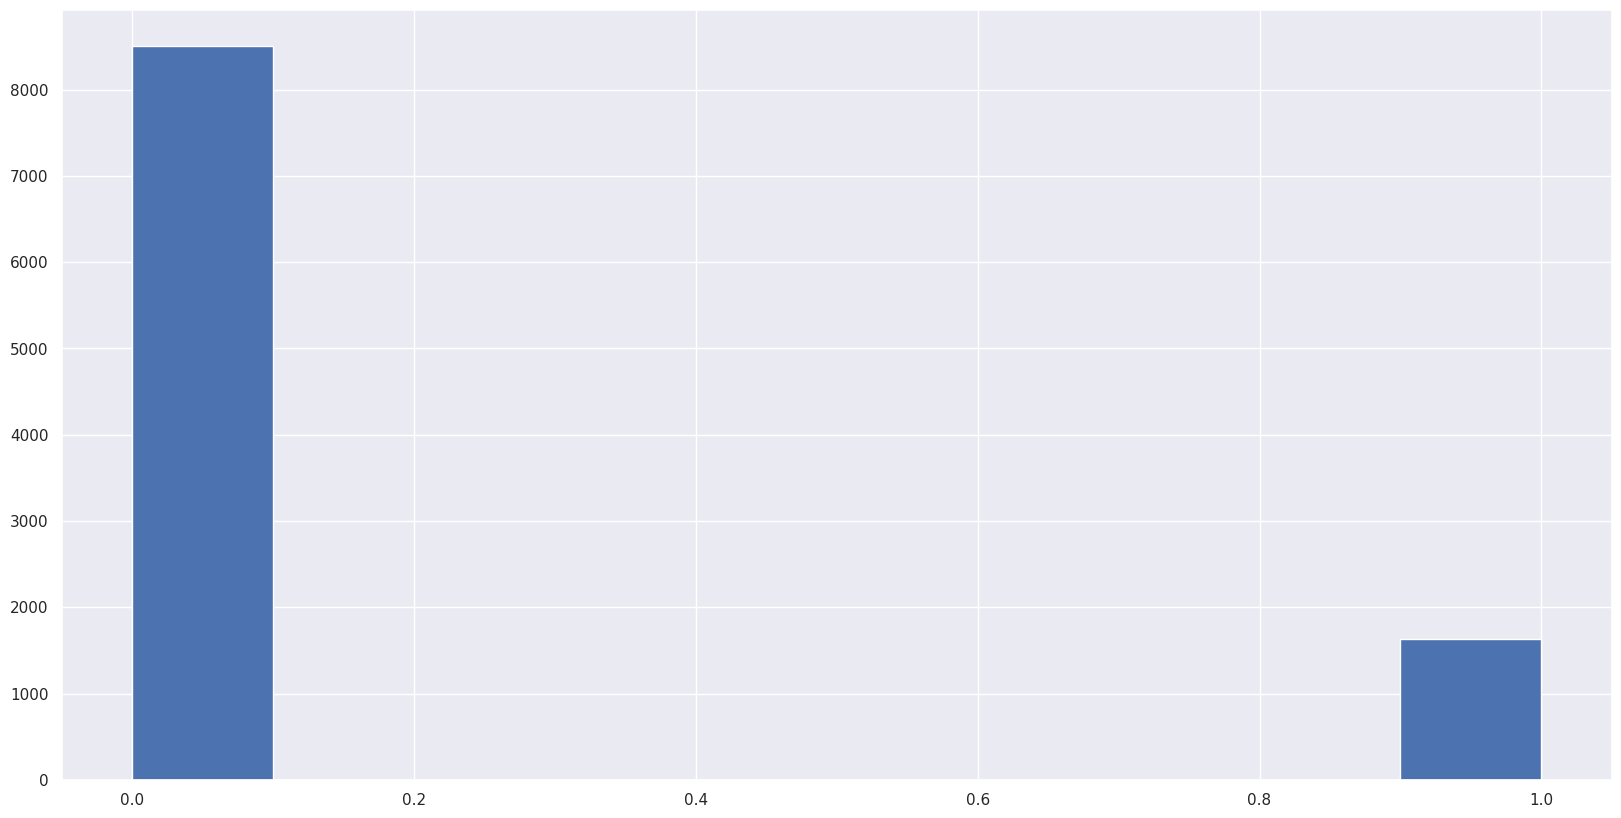

In [13]:
plt.figure(figsize=(20,10)) 
df['Churn'].hist();

In [14]:
df['Churn']

0        0
1        0
2        0
3        0
4        0
        ..
10122    0
10123    1
10124    1
10125    1
10126    1
Name: Churn, Length: 10127, dtype: int64

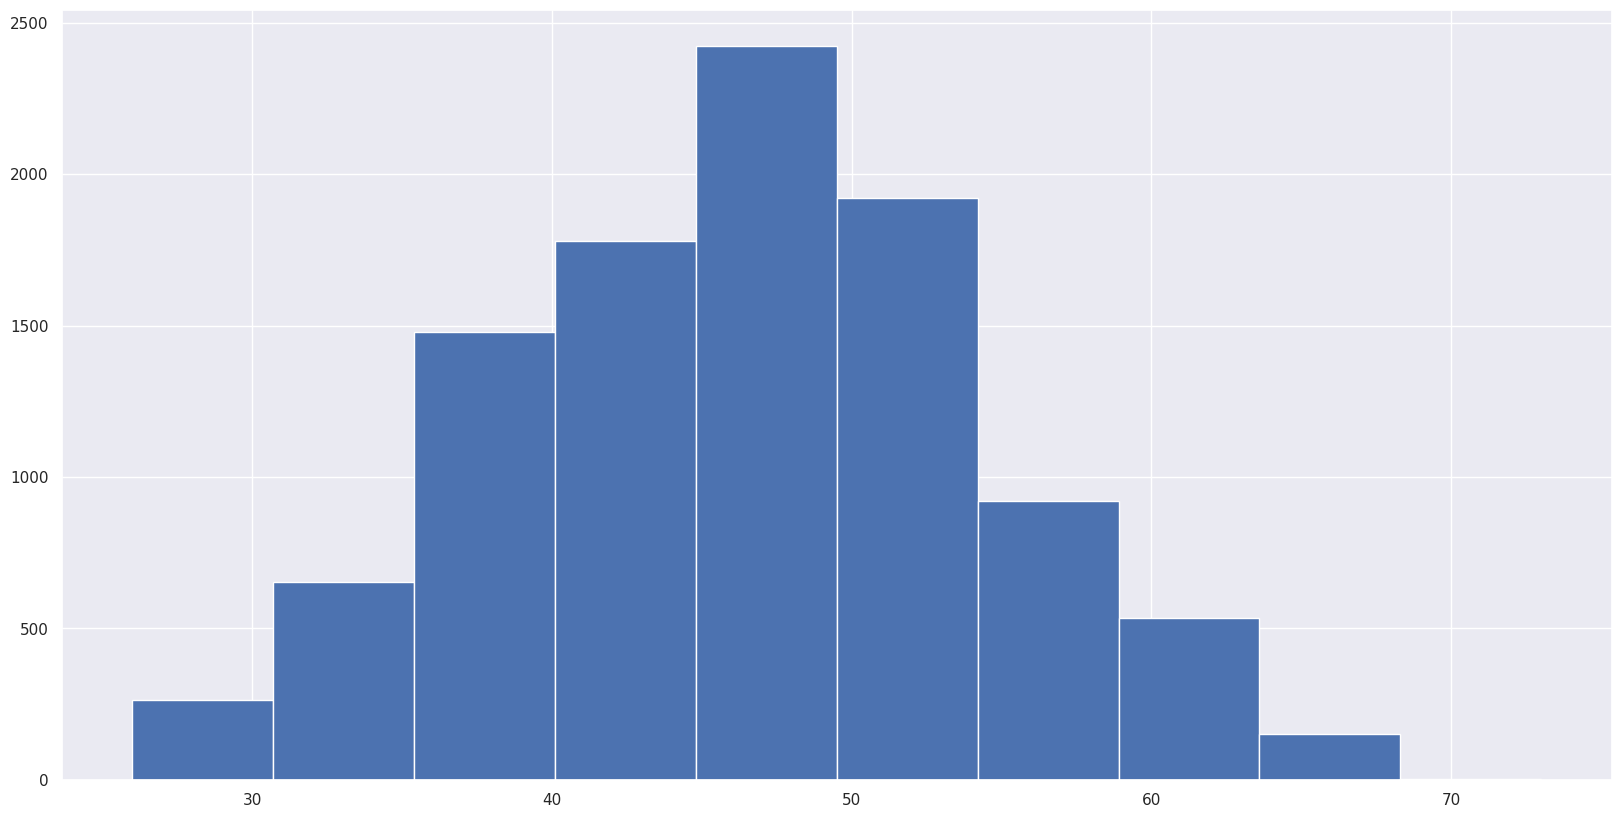

In [15]:
plt.figure(figsize=(20,10)) 
df['Customer_Age'].hist();

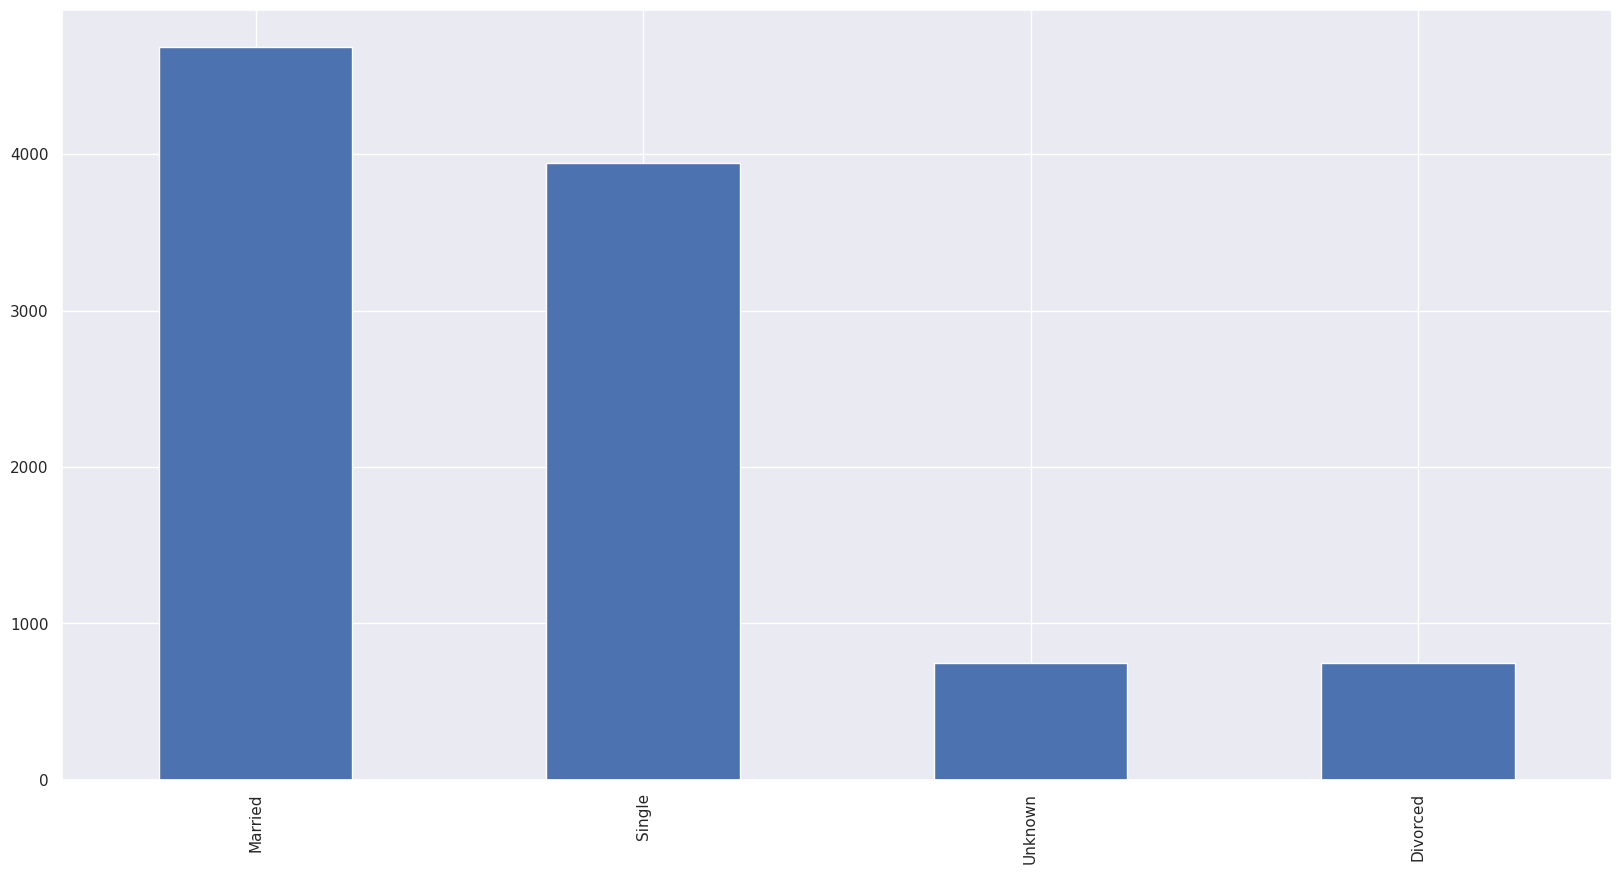

In [16]:
plt.figure(figsize=(20,10)) 
df.Marital_Status.value_counts(normalize=False).plot(kind='bar');

<Axes: >

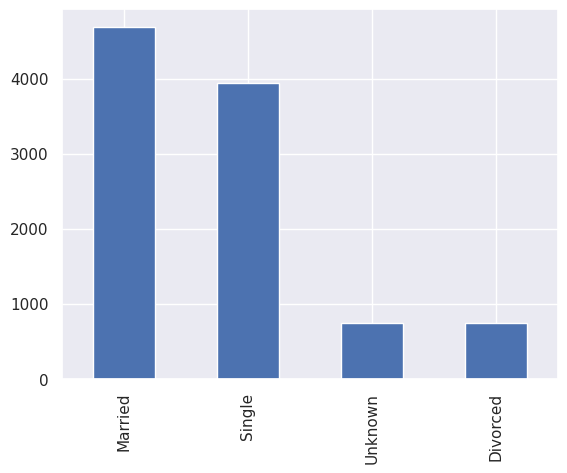

In [17]:
df.Marital_Status.value_counts(None).plot(kind='bar')

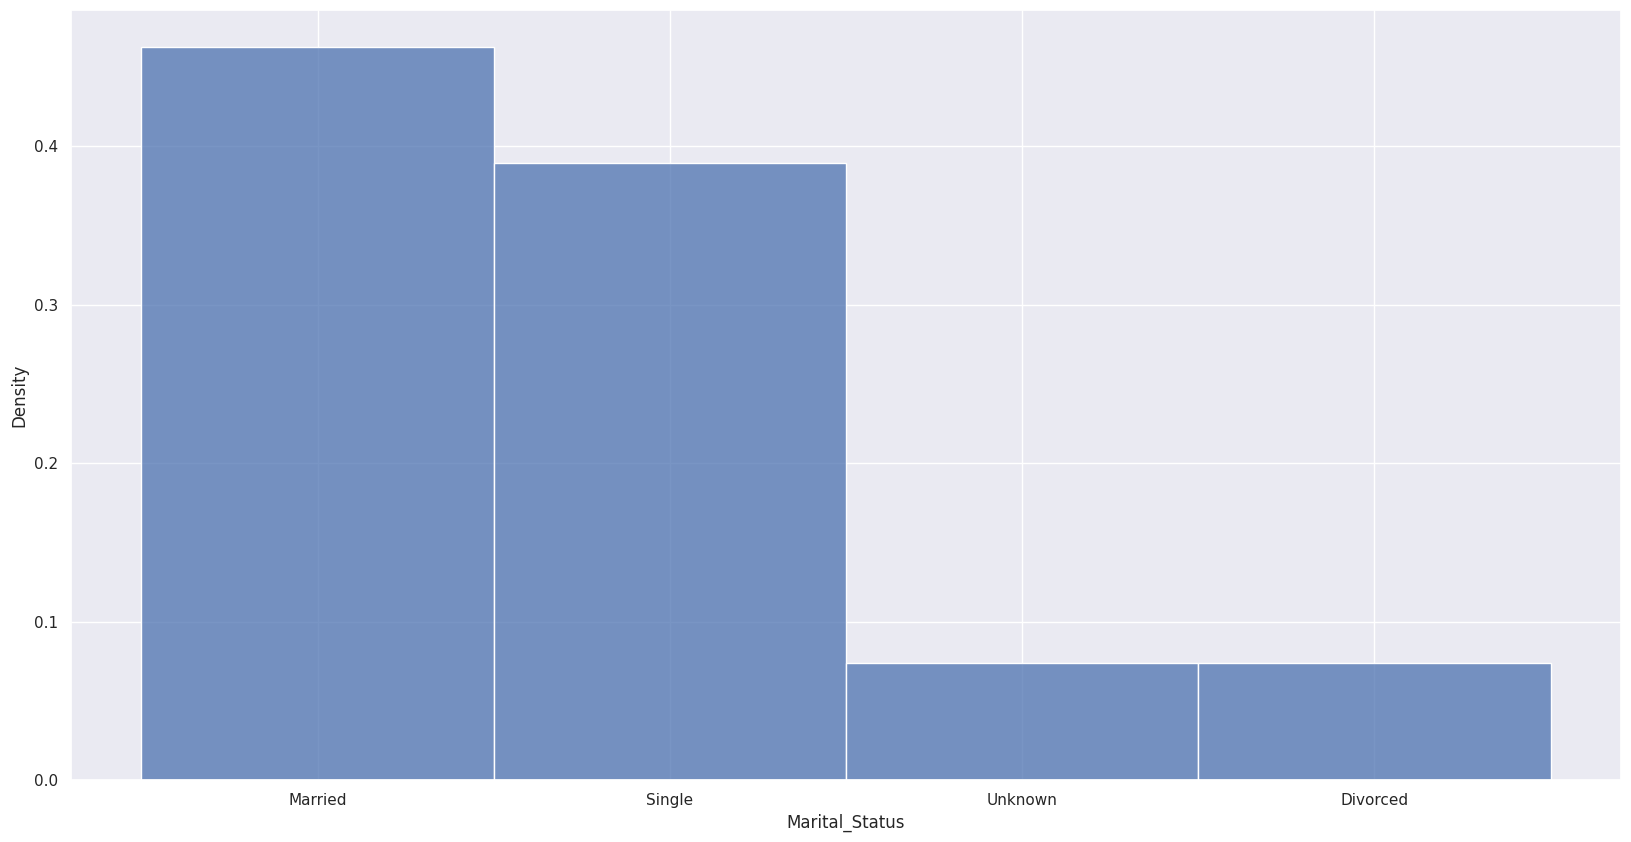

In [18]:
plt.figure(figsize=(20,10)) 
# distplot is deprecated. Use histplot instead
# sns.distplot(df['Total_Trans_Ct']);
# Show distributions of 'Total_Trans_Ct' and add a smooth curve obtained using a kernel density estimate
sns.histplot(df.Marital_Status, stat='density');

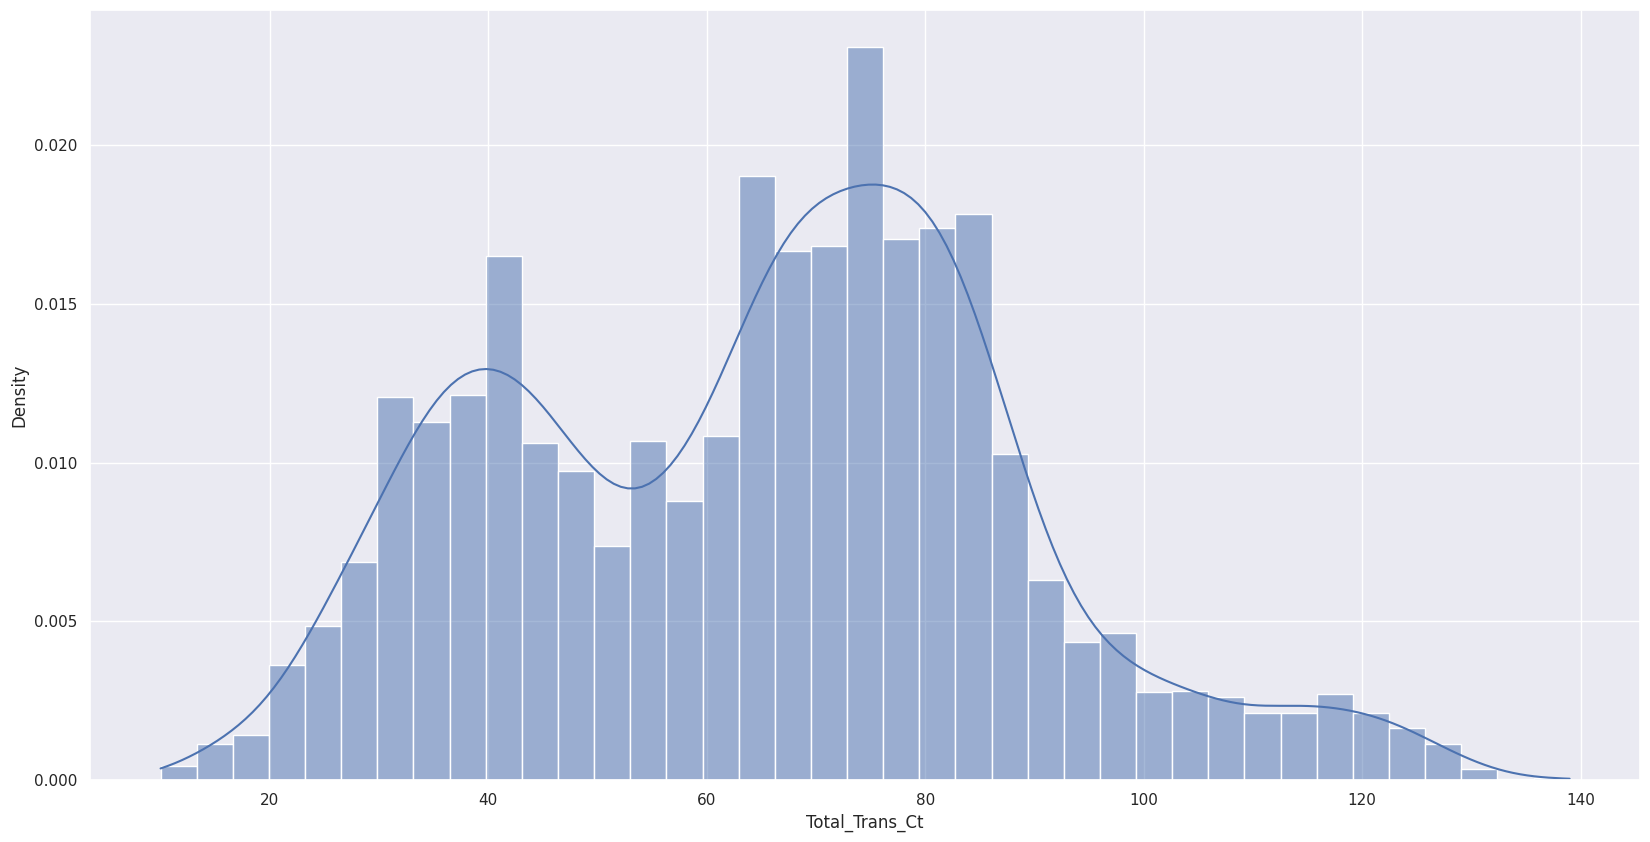

In [19]:
plt.figure(figsize=(20,10)) 
# distplot is deprecated. Use histplot instead
# sns.distplot(df['Total_Trans_Ct']);
# Show distributions of 'Total_Trans_Ct' and add a smooth curve obtained using a kernel density estimate
sns.histplot(df['Total_Trans_Ct'], stat='density', kde=True);

In [20]:
df.corr()

,Unnamed: 0,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
Unnamed: 0,1.000000,-0.028655,-0.010781,0.084230,-0.008814,-0.420573,0.041096,-0.112528,0.019433,-0.057366,0.024572,-0.133324,0.728736,0.696273,-0.010389,-0.037377,0.137109
CLIENTNUM,-0.028655,1.000000,0.007613,0.006772,0.134588,0.006907,0.005729,0.005694,0.005708,0.000825,0.005633,0.017369,-0.019692,-0.002961,0.007696,0.000266,-0.046430
Customer_Age,-0.010781,0.007613,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114,0.018203
Dependent_count,0.084230,0.006772,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135,0.018991
Months_on_book,-0.008814,0.134588,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541,0.013687
Total_Relationship_Count,-0.420573,0.006907,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663,-0.150005
Months_Inactive_12_mon,0.041096,0.005729,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503,0.152449
Contacts_Count_12_mon,-0.112528,0.005694,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471,0.204491
Credit_Limit,0.019433,0.005708,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965,-0.023873
Total_Revolving_Bal,-0.057366,0.000825,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022,-0.263053


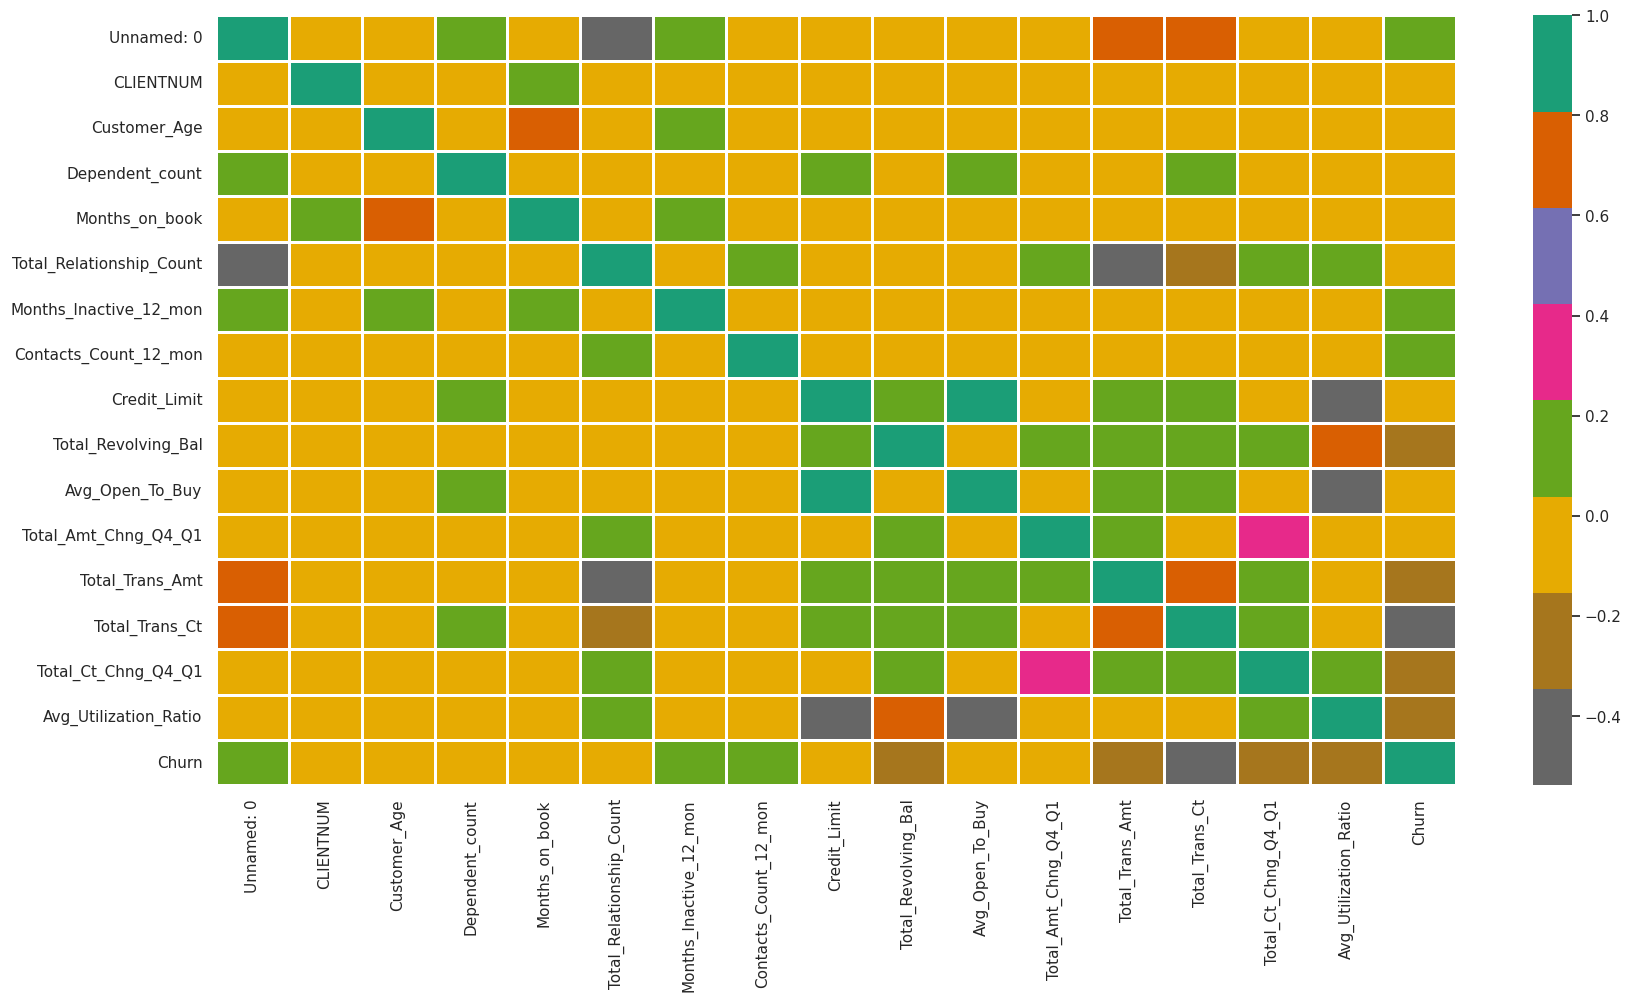

In [21]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=False, cmap='Dark2_r', linewidths = 2)
plt.show()

In [22]:
y = df['Churn']

In [23]:
X = pd.DataFrame()

In [24]:
df

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,...,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0
10123,10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,...,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,1
10124,10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,...,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,1
10125,10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,...,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,1


In [25]:
df.groupby('Gender').mean()

,Unnamed: 0,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
Gender,,,,,,,,,,,,,,,,,
F,5420.867861,7.384748e+08,46.456887,2.340612,35.979097,3.807951,2.351810,2.413587,5023.854274,1140.011198,3883.843076,0.754417,4324.318216,66.352370,0.713525,0.341957,0.173572
M,4660.933319,7.399673e+08,46.178863,2.352485,35.871462,3.817782,2.329209,2.502202,12685.674963,1188.433215,11497.241749,0.766147,4493.706228,63.180541,0.710759,0.199548,0.146152


In [26]:
# gender encoded column
gender_lst = []
gender_groups = df.groupby('Gender').mean()['Churn']

for val in df['Gender']:
    gender_lst.append(gender_groups.loc[val])

df['Gender_Churn'] = gender_lst    
#education encoded column
edu_lst = []
edu_groups = df.groupby('Education_Level').mean()['Churn']

for val in df['Education_Level']:
    edu_lst.append(edu_groups.loc[val])

df['Education_Level_Churn'] = edu_lst

#marital encoded column
marital_lst = []
marital_groups = df.groupby('Marital_Status').mean()['Churn']

for val in df['Marital_Status']:
    marital_lst.append(marital_groups.loc[val])

df['Marital_Status_Churn'] = marital_lst

#income encoded column
income_lst = []
income_groups = df.groupby('Income_Category').mean()['Churn']

for val in df['Income_Category']:
    income_lst.append(income_groups.loc[val])

df['Income_Category_Churn'] = income_lst

#card encoded column
card_lst = []
card_groups = df.groupby('Card_Category').mean()['Churn']
 
for val in df['Card_Category']:
    card_lst.append(card_groups.loc[val])

df['Card_Category_Churn'] = card_lst
    
    

In [27]:
keep_cols = ['Customer_Age', 'Dependent_count', 'Months_on_book',
             'Total_Relationship_Count', 'Months_Inactive_12_mon',
             'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
             'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
             'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
             'Gender_Churn', 'Education_Level_Churn', 'Marital_Status_Churn', 
             'Income_Category_Churn', 'Card_Category_Churn']

X[keep_cols] = df[keep_cols]

In [28]:
X.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_Churn,Education_Level_Churn,Marital_Status_Churn,Income_Category_Churn,Card_Category_Churn
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.146152,0.152012,0.151269,0.134807,0.160979
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.173572,0.155691,0.169414,0.171862,0.160979
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.146152,0.155691,0.151269,0.157655,0.160979
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.173572,0.152012,0.172230,0.171862,0.160979
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.146152,0.159381,0.151269,0.134807,0.160979


In [29]:
# This cell may take up to 15-20 minutes to run
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

# grid search
rfc = RandomForestClassifier(random_state=42)
# Use a different solver if the default 'lbfgs' fails to converge
# Reference: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lrc = LogisticRegression(solver='lbfgs', max_iter=3000)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,100],
    'criterion' :['gini', 'entropy']
}

cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
cv_rfc.fit(X_train, y_train)

lrc.fit(X_train, y_train)

y_train_preds_rf = cv_rfc.best_estimator_.predict(X_train)
y_test_preds_rf = cv_rfc.best_estimator_.predict(X_test)

y_train_preds_lr = lrc.predict(X_train)
y_test_preds_lr = lrc.predict(X_test)

# scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_rf))
print('train results')
print(classification_report(y_train, y_train_preds_rf))

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

random forest results
test results
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2543
           1       0.93      0.80      0.86       496

    accuracy                           0.96      3039
   macro avg       0.95      0.90      0.92      3039
weighted avg       0.96      0.96      0.96      3039

train results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5957
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      7088
   macro avg       1.00      1.00      1.00      7088
weighted avg       1.00      1.00      1.00      7088

logistic regression results
test results
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2543
           1       0.71      0.45      0.55       496

    accuracy                           0.88      3039
   macro avg       0.81      0.71     

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


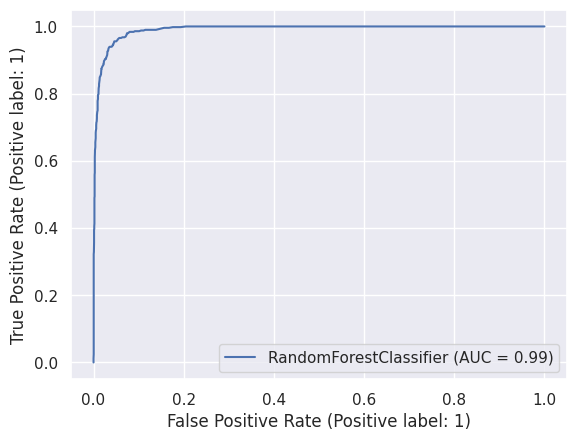

In [30]:
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test)

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


<Figure size 1000x800 with 0 Axes>

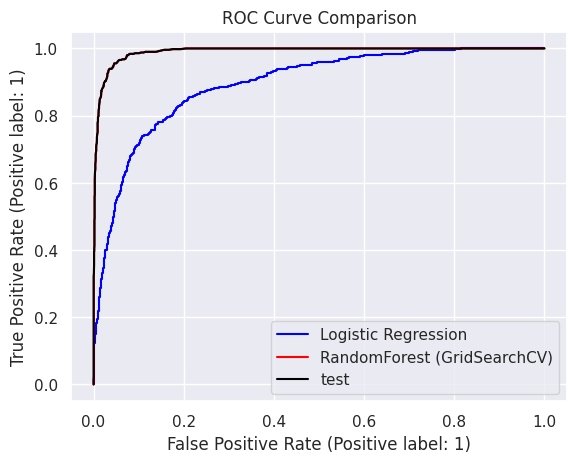

In [31]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for Logistic Regression model
log_disp = plot_roc_curve(lrc, X_test, y_test, label='Logistic Regression', color='blue')

# Plot ROC curve for the best RandomForest model obtained through GridSearchCV
rf_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, label='RandomForest (GridSearchCV)', ax=log_disp.ax_, color='red')

# Plot ROC curve for the best RandomForest model obtained through GridSearchCV
rf_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, **{'label':'test','ax':log_disp.ax_, 'color':'black'})

plt.legend(loc='lower right')
plt.title('ROC Curve Comparison')
# plt.savefig('roc_curve_comparison.png')
plt.show()

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


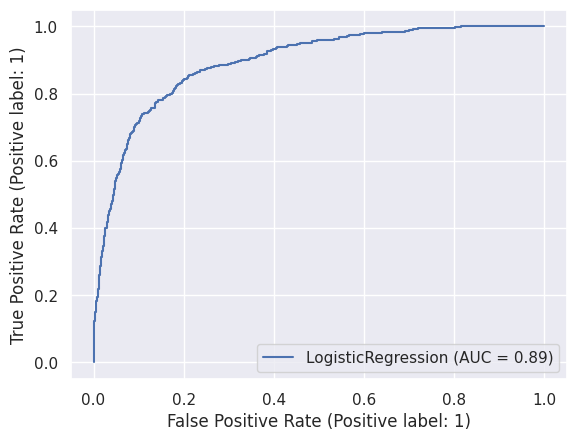

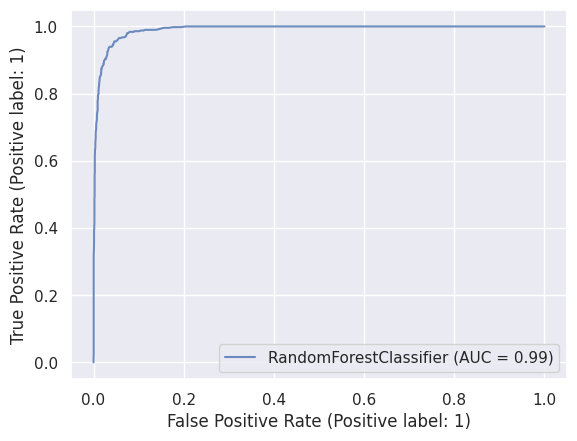

In [32]:
lrc_plot = plot_roc_curve(lrc, X_test, y_test)
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, alpha=0.8)

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


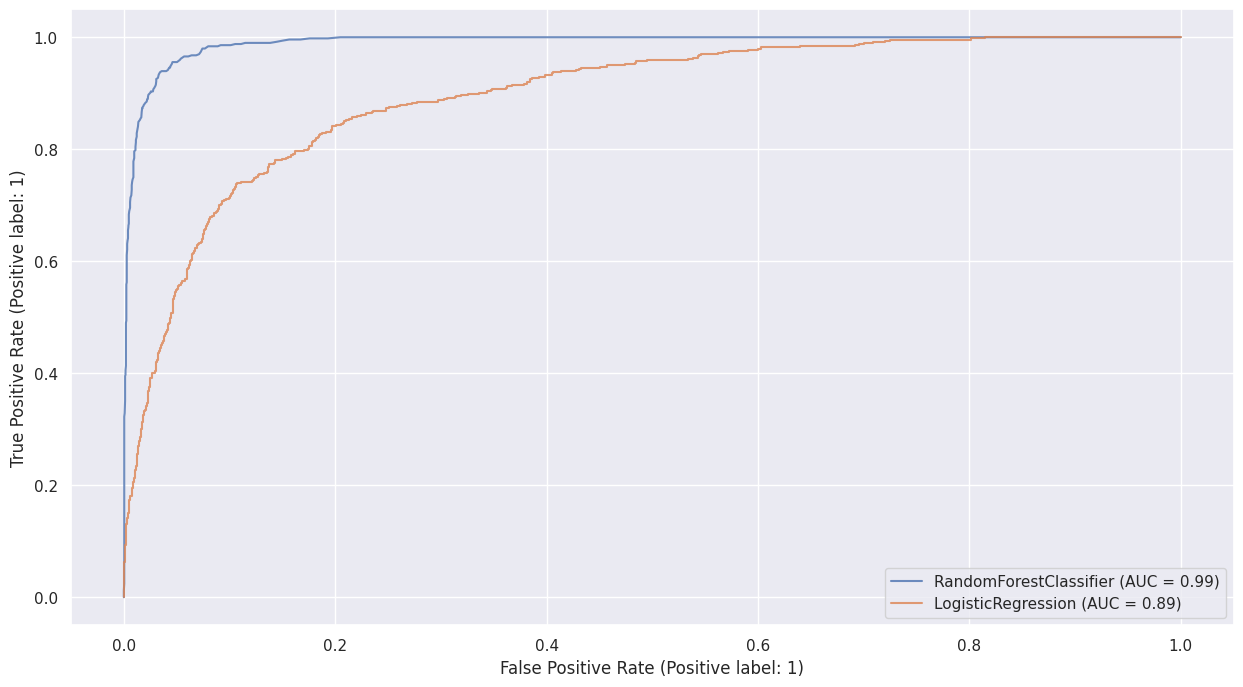

In [33]:
# plots
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_rfc.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

In [34]:
# save best model
joblib.dump(cv_rfc.best_estimator_, './models/rfc_model.pkl')
joblib.dump(lrc, './models/logistic_model.pkl')

['./models/logistic_model.pkl']

In [80]:
rfc_model = joblib.load('./models/rfc_model.pkl')
lr_model = joblib.load('./models/logistic_model.pkl')

In [83]:
type(rfc_model) == RandomForestClassifier

True

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


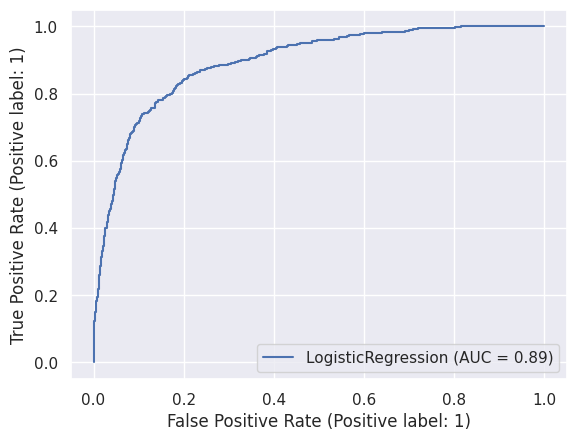

In [36]:
lrc_plot = plot_roc_curve(lr_model, X_test, y_test)

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


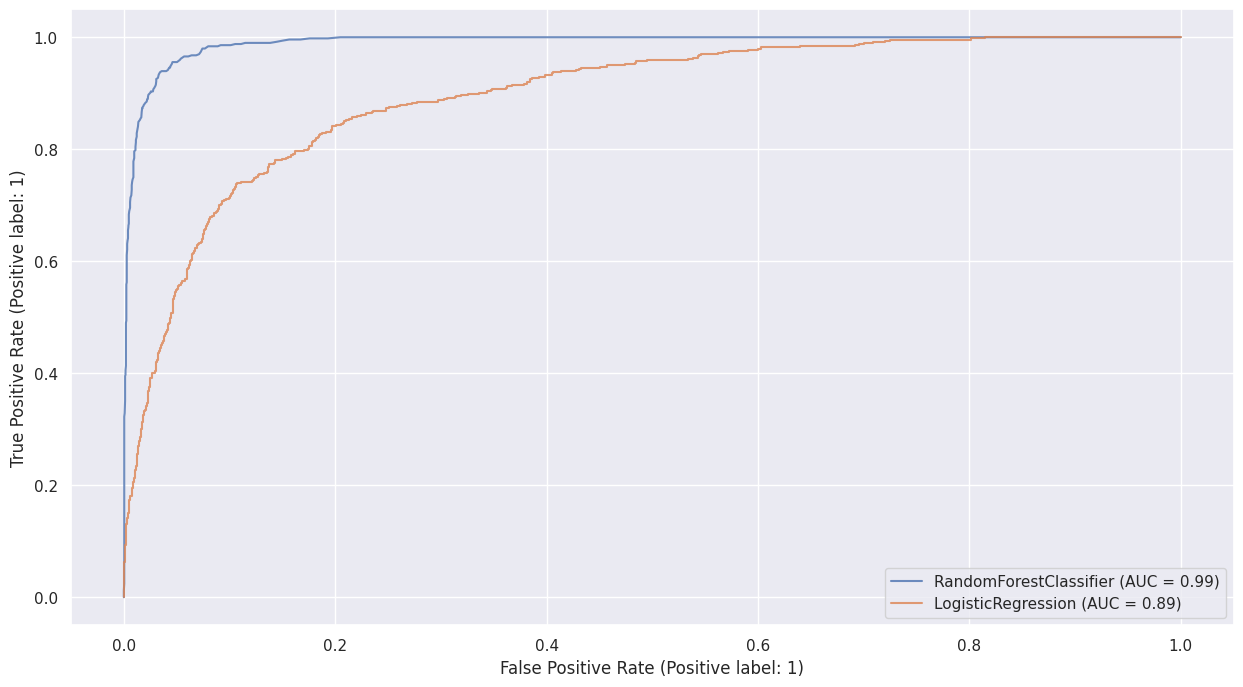

In [37]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc_model, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

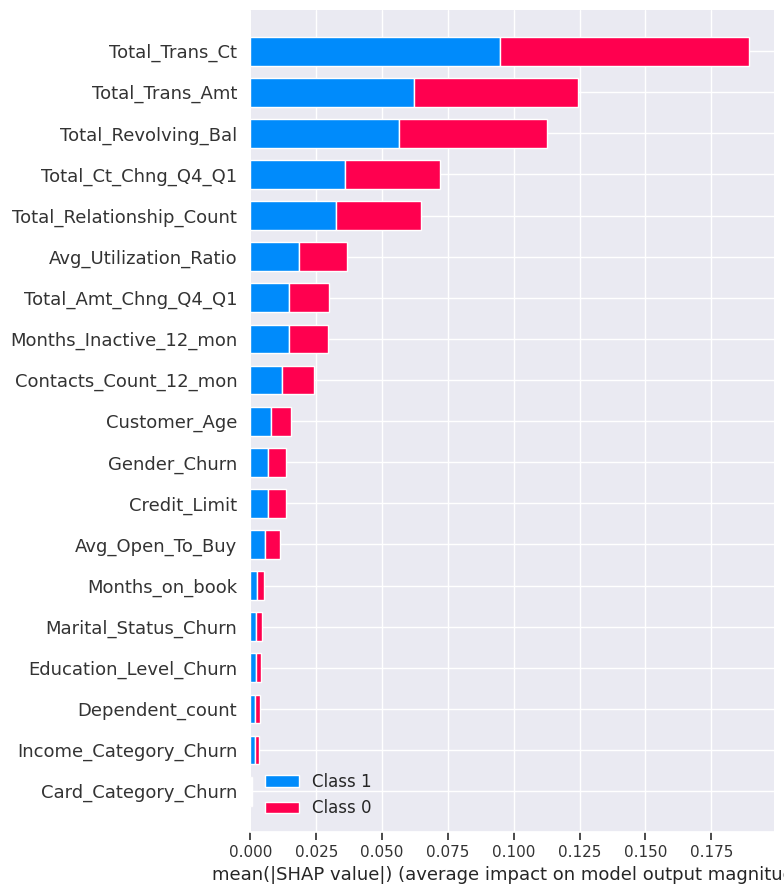

In [38]:
explainer = shap.TreeExplainer(cv_rfc.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [86]:
x = ('models', 'names')
y = (['a', 'b'], ['c', 'e'])

thisdict = dict.fromkeys(x, y)

print(thisdict)

{'models': (['a', 'b'], ['c', 'e']), 'names': (['a', 'b'], ['c', 'e'])}


In [61]:
names

['Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Revolving_Bal',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Relationship_Count',
 'Avg_Utilization_Ratio',
 'Customer_Age',
 'Credit_Limit',
 'Avg_Open_To_Buy',
 'Months_Inactive_12_mon',
 'Months_on_book',
 'Contacts_Count_12_mon',
 'Education_Level_Churn',
 'Dependent_count',
 'Gender_Churn',
 'Income_Category_Churn',
 'Marital_Status_Churn',
 'Card_Category_Churn']

In [74]:
importances[indices]

array([0.20291087, 0.17983949, 0.10828761, 0.0964764 , 0.06580509,
       0.05970112, 0.0539813 , 0.03430138, 0.03410324, 0.03313326,
       0.02620857, 0.0259918 , 0.02394921, 0.01231226, 0.01205982,
       0.01030523, 0.01000476, 0.00849655, 0.00213203])

In [68]:
rounded_array = np.around(importances[indices], decimals=2)*100

In [69]:
rounded_array

array([20., 18., 11., 10.,  7.,  6.,  5.,  3.,  3.,  3.,  3.,  3.,  2.,
        1.,  1.,  1.,  1.,  1.,  0.])

In [70]:
# Generate the final list
final_list = [name for name, count in zip(names, rounded_array) for _ in range(int(count))]

# Display the final list
print(final_list)

['Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Trans_Ct', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q

In [75]:
cv_rfc.best_estimator_.feature_importances_

array([0.03430138, 0.01205982, 0.0259918 , 0.05970112, 0.02620857,
       0.02394921, 0.03410324, 0.10828761, 0.03313326, 0.06580509,
       0.20291087, 0.17983949, 0.0964764 , 0.0539813 , 0.01030523,
       0.01231226, 0.00849655, 0.01000476, 0.00213203])

In [78]:
indices

array([10, 11,  7, 12,  9,  3, 13,  0,  6,  8,  4,  2,  5, 15,  1, 14, 17,
       16, 18])

In [79]:
np.argsort(importances)

array([18, 16, 17, 14,  1, 15,  5,  2,  4,  8,  6,  0, 13,  3,  9, 12,  7,
       11, 10])

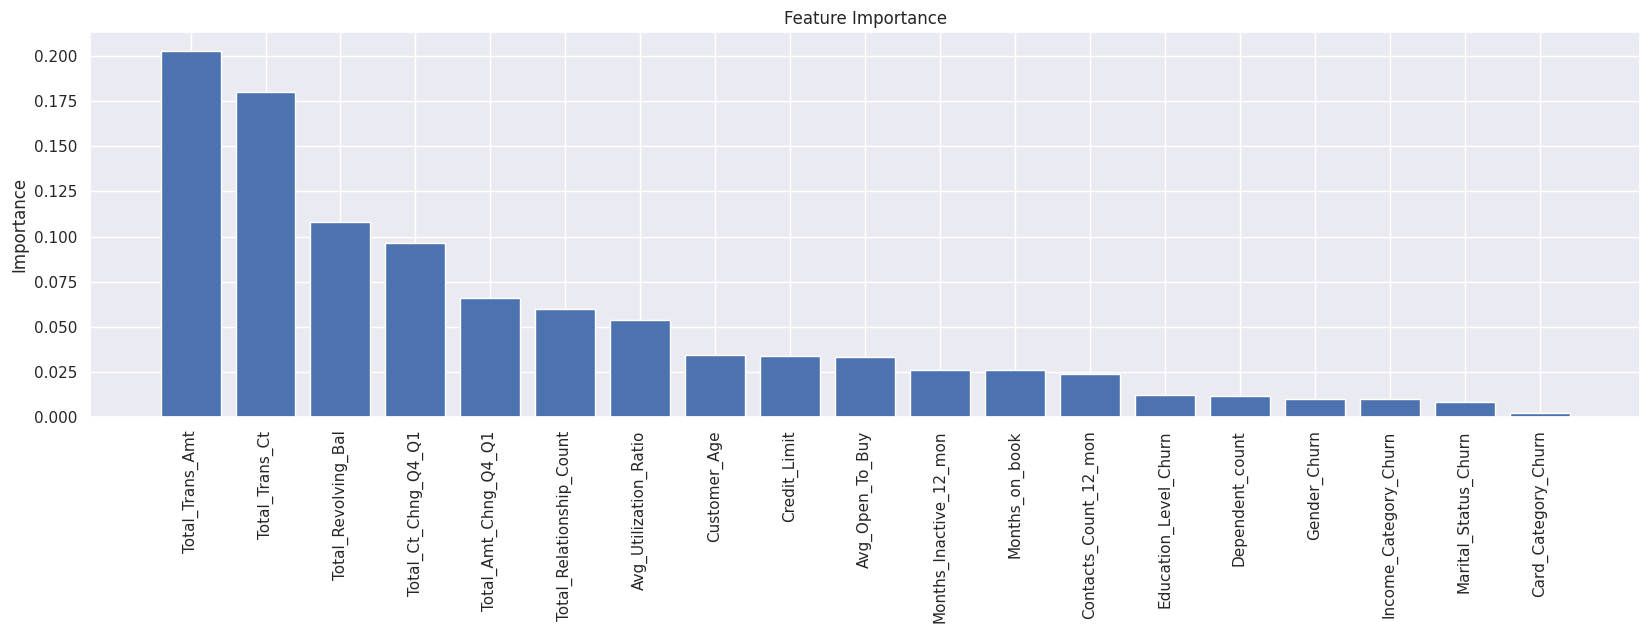

In [77]:
# Calculate feature importances
importances = cv_rfc.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,5))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);

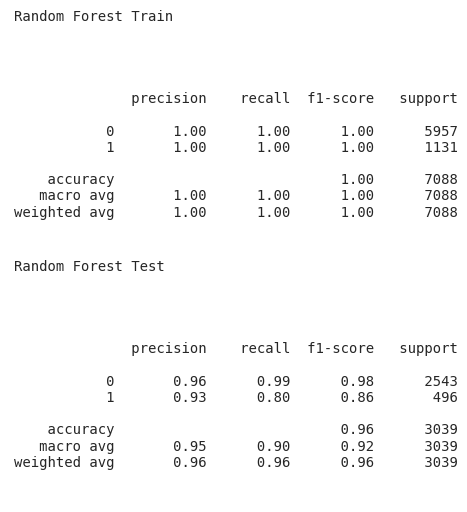

In [40]:
plt.rc('figure', figsize=(5, 5))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_rf)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');


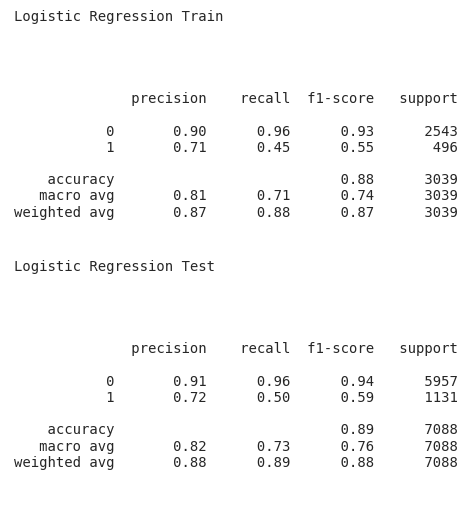

In [41]:
plt.rc('figure', figsize=(5, 5))
plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off');

In [42]:
rfc_model = joblib.load('./models/rfc_model.pkl')
lr_model = joblib.load('./models/logistic_model.pkl')

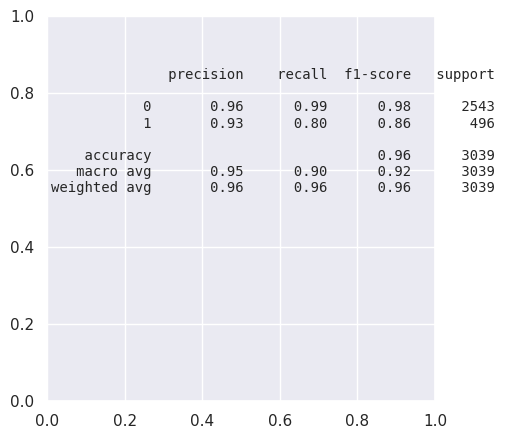

In [46]:
plt.text(0.01, 0.5, str(classification_report(y_test, rfc_model.predict(X_test))), {'fontsize': 10}, fontproperties='monospace')
plt.show()

In [47]:
pd.Series([1,2,3])

0    1
1    2
2    3
dtype: int64

In [50]:
import numpy as np

In [58]:
type(np.array([1,2,3])) == np.ndarray

True

In [56]:
isinstance(rfc_model.predict(X_test), np.ndarray)

True

In [59]:
pd.DataFrame(data = {'column 1':[1,2,3], 'column 2':[1,2,3]})

,column 1,column 2
0,1,1
1,2,2
2,3,3
